In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
raw_data = pd.read_csv('/content/drive/My Drive/bike_sharing_demand.csv', header = 0, sep = ',')

In [6]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
raw_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


Предобработка данных

In [8]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [10]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

In [13]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [14]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [18]:
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'registered', 'casual'], axis=1)

In [19]:
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'registered', 'casual'], axis=1)

In [20]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype=bool)

In [21]:
print(binary_data_columns)
print(binary_data_indices)

['holiday', 'workingday']
[False  True  True False False False False False False False]


In [34]:
categorical_data_columns = ['season', 'weather', 'month']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype=bool)

In [35]:
print(categorical_data_columns)
print(categorical_data_indices)

['season', 'weather', 'month']
[ True False False  True False False False False  True False]


In [24]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype=bool)

In [25]:
print(numeric_data_columns)
print(numeric_data_indices)

['temp', 'atemp', 'humidity', 'windspeed', 'hour']
[False False False False  True  True  True  True False  True]


Pipeline

In [55]:
regressor = linear_model.SGDRegressor(random_state=0, max_iter=3, loss='squared_loss', penalty='l2')

In [56]:
estimator = pipeline.Pipeline(steps=[
                                      ('feature_processing', pipeline.FeatureUnion(transformer_list=[
                                                                                                     #binary
                                                                                                     ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.loc[:, binary_data_indices])),
                                                                                                     
                                                                                                     #numeric
                                                                                                     ('numeric_variables_processing', pipeline.Pipeline(steps=[
                                                                                                      ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numeric_data_indices]))    ,
                                                                                                      ('sorting', preprocessing.StandardScaler(with_mean=0.))                                                     
                                                                                                     ])),

                                                                                                     #categorical
                                                                                                     ('categorical_variables_processing', pipeline.Pipeline(steps=[
                                                                                                      ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, categorical_data_indices]))    ,
                                                                                                      ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))                                                     
                                                                                                     ])),
                                      ])),
                                     ('model_fitting', regressor)      
])

In [57]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x7f97099be378>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     validate=False)),
                                                ('numeric_variables_processing',
                                                 Pipeline(memory=None,
                           

In [58]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

120.17177172806858

Подбор параметров

In [59]:
list(estimator.get_params().keys())

['memory',
 'steps',
 'verbose',
 'feature_processing',
 'model_fitting',
 'feature_processing__n_jobs',
 'feature_processing__transformer_list',
 'feature_processing__transformer_weights',
 'feature_processing__verbose',
 'feature_processing__binary_variables_processing',
 'feature_processing__numeric_variables_processing',
 'feature_processing__categorical_variables_processing',
 'feature_processing__binary_variables_processing__accept_sparse',
 'feature_processing__binary_variables_processing__check_inverse',
 'feature_processing__binary_variables_processing__func',
 'feature_processing__binary_variables_processing__inv_kw_args',
 'feature_processing__binary_variables_processing__inverse_func',
 'feature_processing__binary_variables_processing__kw_args',
 'feature_processing__binary_variables_processing__validate',
 'feature_processing__numeric_variables_processing__memory',
 'feature_processing__numeric_variables_processing__steps',
 'feature_processing__numeric_variables_processin

In [60]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
}

In [61]:
grid_cv = model_selection.GridSearchCV(estimator, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [64]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 1.02 s, sys: 9.75 ms, total: 1.03 s
Wall time: 1.04 s


GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feature_processing',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function <lambda> at 0x7f97099be378>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                            kw_args=None,


In [65]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-106.60524061317199
{'model_fitting__alpha': 0.001, 'model_fitting__eta0': 0.05}


Оценка на отложенном тесте

In [66]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [67]:
metrics.mean_absolute_error(test_labels, test_predictions)

125.11055616822885

In [68]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [69]:
print(test_predictions[:20])

[153.28859124 181.89867268 227.64068051 262.47727954 278.91095558
 279.82091706 301.6223314  333.35079391 336.28447325 348.55425173
 346.29477487 336.77206344 318.29674096 298.65247956 285.35831745
 246.0338046  252.72004984  58.96734361  66.43816405  73.90898448]


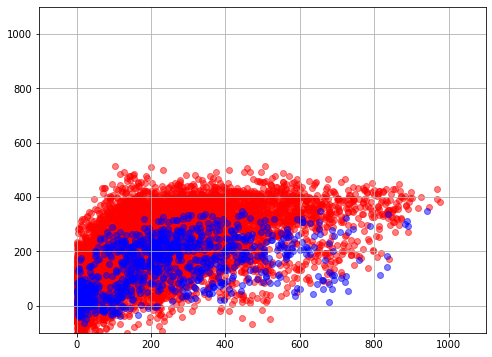

In [72]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')

Другая модель

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=50)


In [76]:
estimator = pipeline.Pipeline(steps=[
                                      ('feature_processing', pipeline.FeatureUnion(transformer_list=[
                                                                                                     #binary
                                                                                                     ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.loc[:, binary_data_indices])),
                                                                                                     
                                                                                                     #numeric
                                                                                                     ('numeric_variables_processing', pipeline.Pipeline(steps=[
                                                                                                      ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, numeric_data_indices]))    ,
                                                                                                      ('sorting', preprocessing.StandardScaler(with_mean=0.))                                                     
                                                                                                     ])),

                                                                                                     #categorical
                                                                                                     ('categorical_variables_processing', pipeline.Pipeline(steps=[
                                                                                                      ('selecting', preprocessing.FunctionTransformer(lambda data: data.loc[:, categorical_data_indices]))    ,
                                                                                                      ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))                                                     
                                                                                                     ])),
                                      ])),
                                     ('model_fitting', regressor)      
])

In [77]:
estimator.fit(train_data, train_labels)

Pipeline(memory=None,
         steps=[('feature_processing',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('binary_variables_processing',
                                                 FunctionTransformer(accept_sparse=False,
                                                                     check_inverse=True,
                                                                     func=<function <lambda> at 0x7f9709fbef28>,
                                                                     inv_kw_args=None,
                                                                     inverse_func=None,
                                                                     kw_args=None,
                                                                     validate=False)),
                                                ('numeric_variables_processing',
                                                 Pipeline(memory=None,
                           

In [78]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

79.49758619912876

In [80]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446])

In [81]:
estimator.predict(test_data)[:10]

array([409.565     , 505.56      , 256.06066667, 165.6502619 ,
       205.82474784, 265.91960439, 254.61615818, 317.85774486,
       280.98963263, 434.51333333])

Text(0.5, 1.0, 'random forest model')

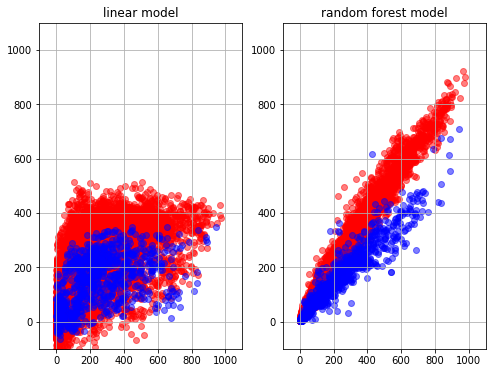

In [84]:
pylab.figure(figsize=(8, 6))

pylab.subplot(1, 2, 1)
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color='blue')
pylab.title('linear model')

pylab.subplot(1, 2, 2)
pylab.grid(True)
pylab.xlim(-100, 1100)
pylab.ylim(-100, 1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color='red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color='blue')
pylab.title('random forest model')